In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def load_and_prepare_data(truck_data, claim_data):
    """
    Load and prepare the data for analysis
    """
    # Convert claim costs to numeric (assuming 'Very Low' = 1, 'Low' = 2, etc.)
    cost_mapping = {'Very Low': 1, 'Low': 2, 'Medium': 3, 'High': 4, 'Very High': 5}

    # Prepare claims data
    claims_df = claim_data.copy()
    claims_df['Scale_Claim_Cost_Numeric'] = claims_df['Scale Claim Cost'].map(cost_mapping)
    claims_df['Scale_Labor_Cost_Numeric'] = claims_df['Scale Labor Cost'].map(cost_mapping)

    # Aggregate claims by truck
    claims_agg = claims_df.groupby('Truck Number').agg({
        'Scale_Claim_Cost_Numeric': ['count', 'mean', 'sum'],
        'Scale_Labor_Cost_Numeric': ['mean', 'sum']
    }).reset_index()

    # Flatten column names
    claims_agg.columns = ['Truck_Number', 'Claim_Count', 'Avg_Claim_Cost',
                         'Total_Claim_Cost', 'Avg_Labor_Cost', 'Total_Labor_Cost']

    # Merge with truck attributes
    merged_df = pd.merge(truck_data, claims_agg,
                        left_on='Truck', right_on='Truck_Number',
                        how='left')

    # Fill NAs with 0 for trucks with no claims
    merged_df = merged_df.fillna(0)

    return merged_df


In [ ]:
def analyze_individual_attributes(df):
    """
    Analyze individual attributes' impact on warranty costs
    """
    results = {}
    attributes = ['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4',
                 'Attribute 5', 'Attribute 6', 'Attribute 7', 'Attribute 8']

    for attr in attributes:
        # Perform Kruskal-Wallis H-test
        groups = [group['Total_Claim_Cost'].values for name, group in df.groupby(attr)]
        h_stat, p_value = stats.kruskal(*groups)

        # Calculate mean cost per option
        mean_costs = df.groupby(attr)['Total_Claim_Cost'].mean()

        results[attr] = {
            'p_value': p_value,
            'significant': p_value < 0.05,
            'mean_costs': mean_costs
        }

    return results

In [ ]:
def analyze_attribute_pairs(df):
    """
    Analyze interaction between attribute pairs
    """
    attributes = ['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4',
                 'Attribute 5', 'Attribute 6', 'Attribute 7', 'Attribute 8']

    interaction_results = []

    for i in range(len(attributes)):
        for j in range(i+1, len(attributes)):
            attr1, attr2 = attributes[i], attributes[j]

            # Create interaction term
            df[f'{attr1}_{attr2}'] = df[attr1].astype(str) + '_' + df[attr2].astype(str)

            # Perform Kruskal-Wallis test on interaction
            groups = [group['Total_Claim_Cost'].values for name, group in df.groupby(f'{attr1}_{attr2}')]
            h_stat, p_value = stats.kruskal(*groups)

            # Calculate mean costs for combination
            mean_cost = df.groupby(f'{attr1}_{attr2}')['Total_Claim_Cost'].mean()
            max_cost_combo = mean_cost.idxmax()

            interaction_results.append({
                'Attribute_1': attr1,
                'Attribute_2': attr2,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'max_cost_combination': max_cost_combo,
                'max_cost': mean_cost.max()
            })

    return pd.DataFrame(interaction_results)

In [ ]:
def build_predictive_model(df):
    """
    Build a Random Forest model to predict warranty costs
    """
    # Prepare features
    le = LabelEncoder()
    X = df[['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4',
            'Attribute 5', 'Attribute 6', 'Attribute 7', 'Attribute 8']].apply(le.fit_transform)
    y = df['Total_Claim_Cost']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return {
        'model': rf_model,
        'feature_importance': feature_importance,
        'test_score': rf_model.score(X_test, y_test)
    }


In [ ]:
def generate_analysis_report(truck_data, claim_data):
    """
    Generate comprehensive analysis report
    """
    # Prepare data
    merged_df = load_and_prepare_data(truck_data, claim_data)

    # 1. Individual attribute analysis
    individual_results = analyze_individual_attributes(merged_df)

    # 2. Attribute pairs analysis
    pair_results = analyze_attribute_pairs(merged_df)

    # 3. Predictive modeling
    model_results = build_predictive_model(merged_df)

    return {
        'individual_analysis': individual_results,
        'pair_analysis': pair_results,
        'predictive_model': model_results
    }

In [ ]:


def main():
    """
    Main function to execute the analysis pipeline
    """
    # Load your data from sample_data
    truck_data = pd.read_excel('/content/sample_data/Option.xlsx')
    claim_data = pd.read_excel('/content/sample_data/Claim.xlsx')


    # Generate analysis report
    report = generate_analysis_report(truck_data, claim_data)

    # Print or save the report as needed
    print(report)

if __name__ == "__main__":
    main()

{'individual_analysis': {'Attribute 1': {'p_value': 0.0, 'significant': True, 'mean_costs': Attribute 1
Option 1     20.907407
Option 10     3.431953
Option 11     4.787190
Option 12     3.804878
Option 13     1.777778
               ...    
Option 8      3.438719
Option 80     0.441860
Option 81     1.000000
Option 82     5.285714
Option 9      4.217687
Name: Total_Claim_Cost, Length: 82, dtype: float64}, 'Attribute 2': {'p_value': 0.0, 'significant': True, 'mean_costs': Attribute 2
Option 100    8.393249
Option 101    5.165939
Option 102    4.187358
Option 103    5.564246
Option 104    3.186441
                ...   
Option 95     2.526502
Option 96     4.692308
Option 97     6.862400
Option 98     5.857006
Option 99     4.222094
Name: Total_Claim_Cost, Length: 98, dtype: float64}, 'Attribute 3': {'p_value': 0.0, 'significant': True, 'mean_costs': Attribute 3
Option 181    3.492963
Option 182    4.648936
Option 183    4.900361
Option 184    6.882353
Option 185    5.548223
Option 186 

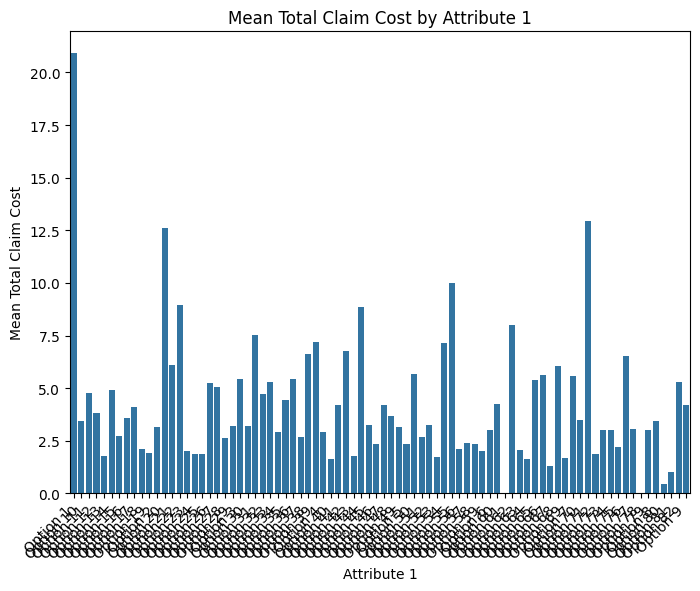

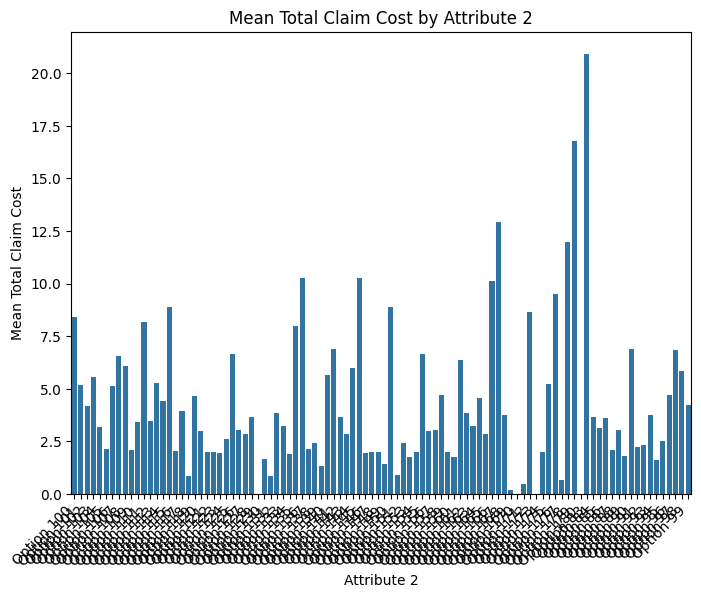

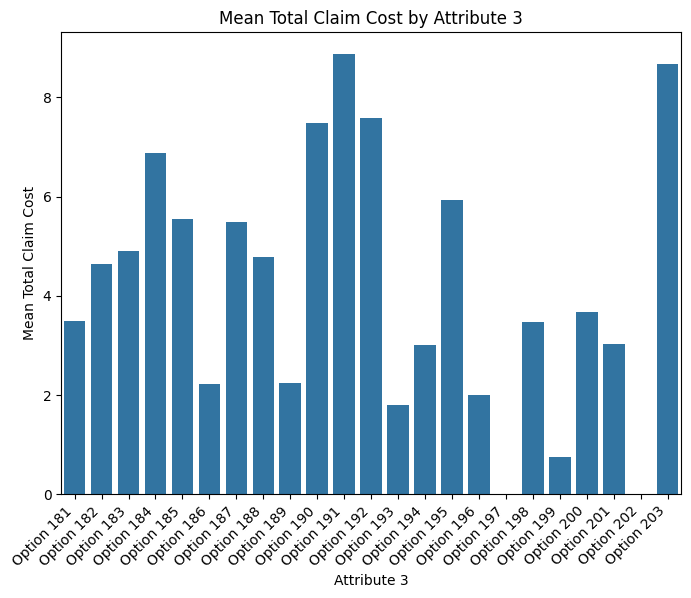

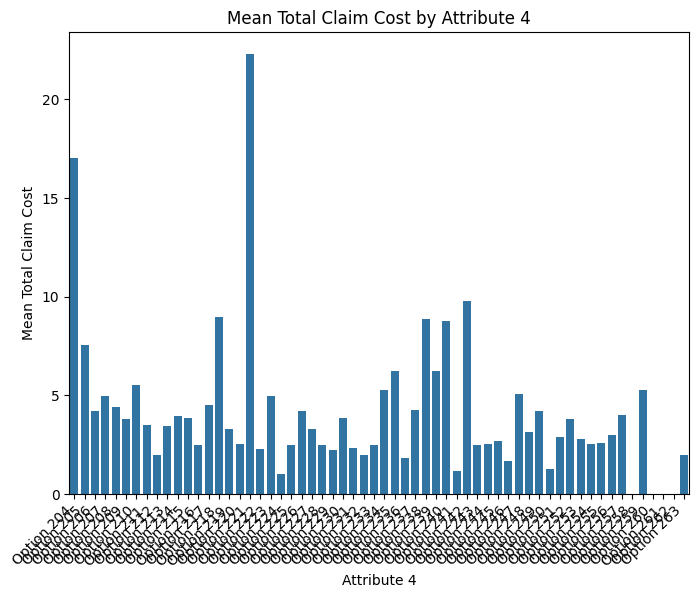

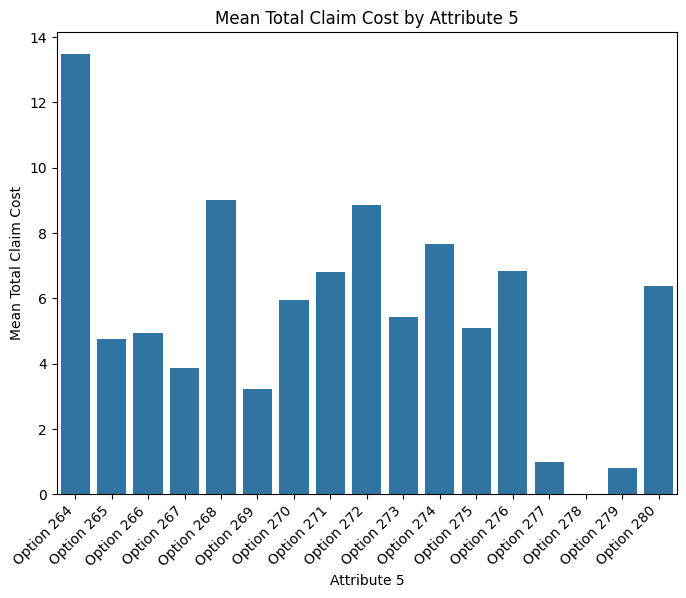

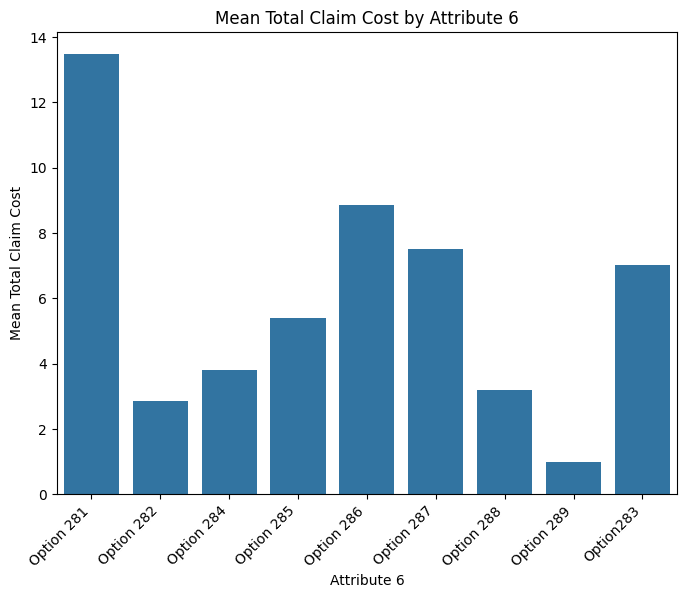

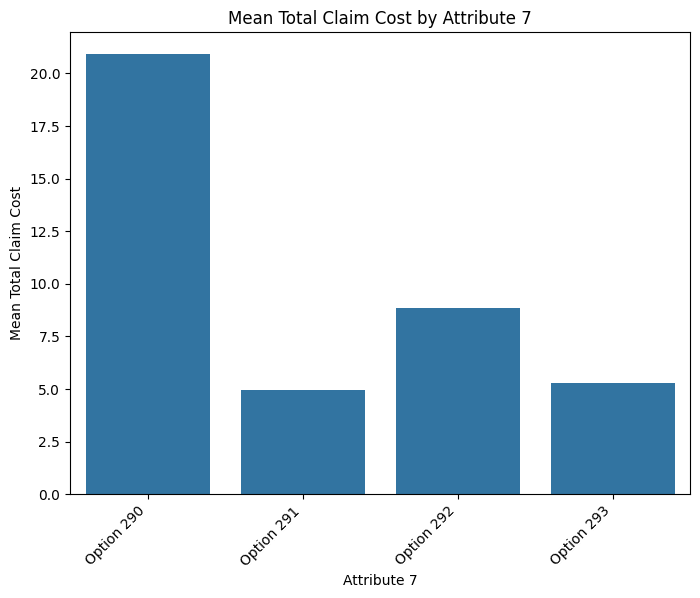

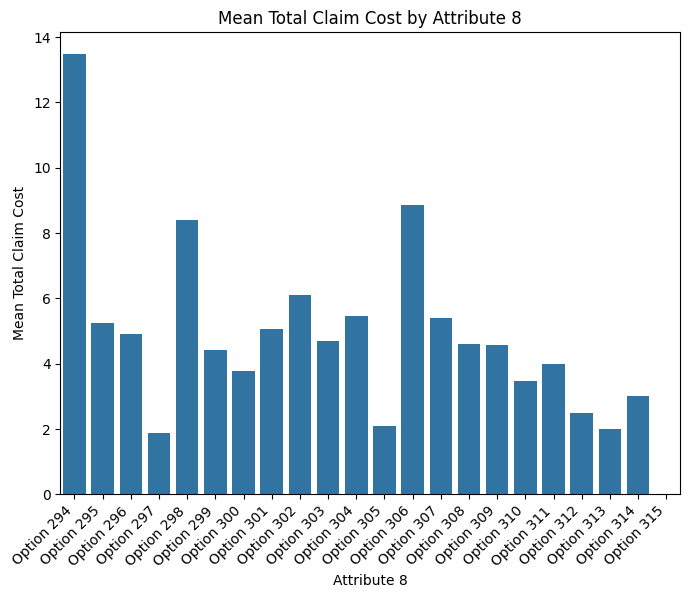

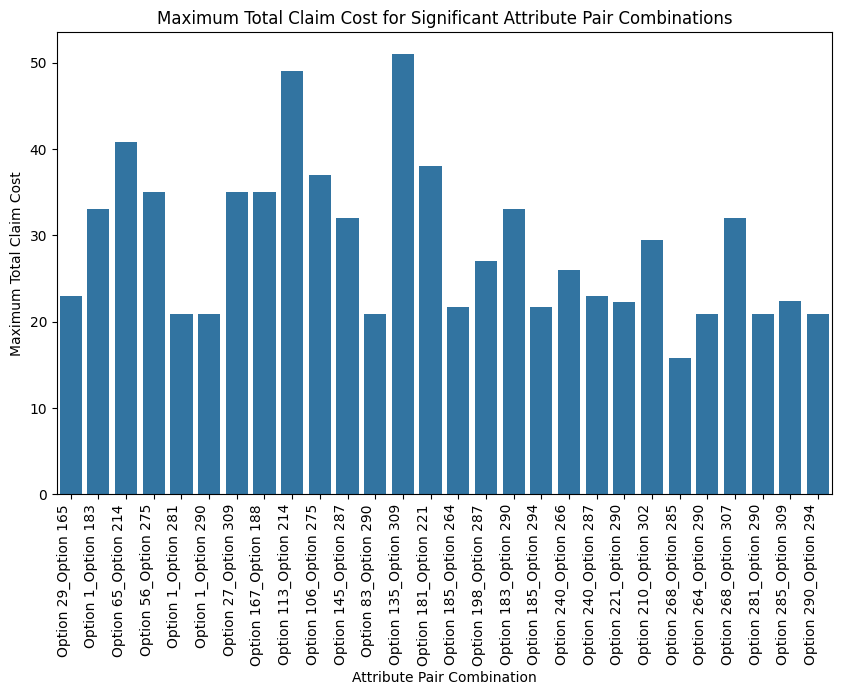

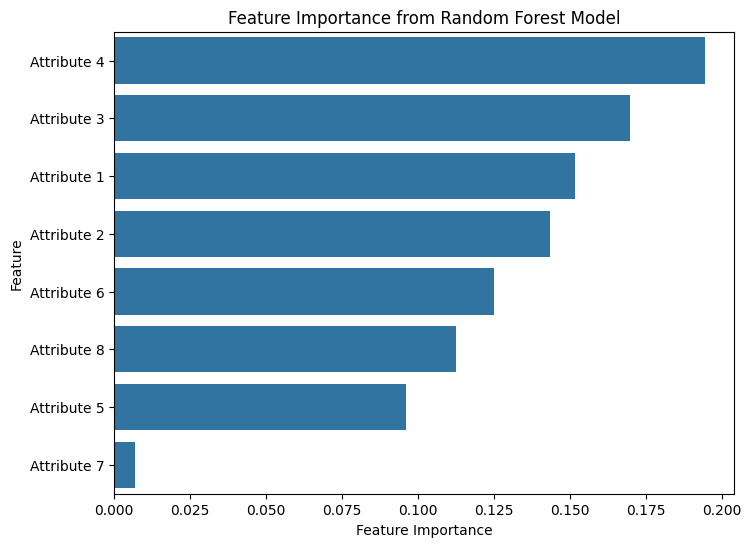

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_analysis_results(report):
  """
  Generates visualizations for the analysis report.
  """

  # 1. Visualize individual attribute analysis
  for attr, results in report['individual_analysis'].items():
    if results['significant']:
      plt.figure(figsize=(8, 6))
      sns.barplot(x=results['mean_costs'].index, y=results['mean_costs'].values)
      plt.title(f"Mean Total Claim Cost by {attr}")
      plt.xlabel(attr)
      plt.ylabel("Mean Total Claim Cost")
      plt.xticks(rotation=45, ha='right')
      plt.show()

  # 2. Visualize attribute pair analysis
  pair_results_df = report['pair_analysis']
  significant_pairs = pair_results_df[pair_results_df['significant']]
  if not significant_pairs.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='max_cost_combination', y='max_cost', data=significant_pairs)
    plt.title("Maximum Total Claim Cost for Significant Attribute Pair Combinations")
    plt.xlabel("Attribute Pair Combination")
    plt.ylabel("Maximum Total Claim Cost")
    plt.xticks(rotation=90, ha='right')
    plt.show()

  # 3. Visualize predictive model feature importance
  feature_importance = report['predictive_model']['feature_importance']
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importance)
  plt.title("Feature Importance from Random Forest Model")
  plt.xlabel("Feature Importance")
  plt.ylabel("Feature")
  plt.show()

  # You can add more visualizations as needed, for example:
  # - Heatmap for correlation between attributes
  # - Histogram of total claim costs
  # - Scatter plot of total claim cost vs. specific attributes


def main():
  # ... (Your existing code to generate the report) ...
    """
    Main function to execute the analysis pipeline
    """
    # Load your data from sample_data
    truck_data = pd.read_excel('/content/sample_data/Option.xlsx')  # Replace with your truck data file
    claim_data = pd.read_excel('/content/sample_data/Claim.xlsx')  # Replace with your claim data file


    # Generate analysis report
    report = generate_analysis_report(truck_data, claim_data)
    # report = generate_analysis_report(truck_data, claim_data)
    visualize_analysis_results(report)

if __name__ == "__main__":
    main()